In [3]:
# Bibliothek für mehr-D Daten (speziell für NetCDF-Daten; Zeit, geografische Koordinaten, ...)
import xarray as xr
import dask

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [5]:
## Auswahl der Daten

# xr.open_dataset = Funktion, um Datensatz im NetDCF-Format öffnen
ds_slp = xr.open_dataset(
    "/home/jovyan/my_materials/data/slp_1m.nc",
    # aktiviert Lazy-Loading mit Bibliothek Dask
    # Dask teilt Datensatz in kleinere Chunks auf, die nur bei Bedarf geladen werden in Arbeitsspeicher
    chunks="auto",
)
# Funktion von xarray.Dataset rename
ds_slp = ds_slp.rename_vars(msl="slp")

# Umbennen
ds_slp = ds_slp.rename({'latitude': 'lat', 'longitude': 'lon'})

# Übersicht des Datensatz wird angezeigt
ds_slp

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 721, lon: 1440, time: 382)
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    slp      (time, lat, lon) float32 2GB dask.array<chunksize=(167, 316, 633), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
## Regionen festlegen

# Region 40S definieren (nächstgelegene Breite -40)
slp_region_40S = ds_slp.sel(lat=-40, method="nearest")
# Region 65S definieren (nächstgelegene Breite -65)
slp_region_65S = ds_slp.sel(lat=-65, method="nearest")

print(slp_region_40S, "\n", slp_region_65S)

<xarray.Dataset> Size: 2MB
Dimensions:  (lon: 1440, time: 382)
Coordinates:
    lat      float64 8B -40.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    slp      (time, lon) float32 2MB dask.array<chunksize=(167, 633), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1... 
 <xarray.Dataset> Size: 2MB
Dimensions:  (lon: 1440, time: 382)
Coordinates:
    lat      float64 8B -65.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    s

In [4]:
## zonale Mittel berechnen / Jahr

# berechnet SLP-Durchschnitt für 40S / Jahr (ohne Dimension lon)
slp_40S_yearly_mean = slp_region_40S.groupby('time.year').mean(dim=['time', 'lon'])
# berechnet SLP-Durchschnitt für 65S / Jahr (ohne Dimension lon)
slp_65S_yearly_mean = slp_region_65S.groupby('time.year').mean(dim=['time', 'lon'])

print(slp_40S_yearly_mean, "\n", slp_65S_yearly_mean)

<xarray.Dataset> Size: 392B
Dimensions:  (year: 32)
Coordinates:
    lat      float64 8B -40.0
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1... 
 <xarray.Dataset> Size: 392B
Dimensions:  (year: 32)
Coordinates:
    lat      float64 8B -65.0
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range 

In [5]:
## Differenz beider Regionen berechnen

slp_diff_yearly = slp_40S_yearly_mean - slp_65S_yearly_mean

print(slp_diff_yearly)

# Konvertiere slp_diff_yearly in ein DataArray
slp_diff_yearly = slp_diff_yearly.to_array().squeeze()

# Variable slp_diff_yearly zum Dataset hinzufügen
ds_slp['slp_diff_yearly'] = slp_diff_yearly

<xarray.Dataset> Size: 384B
Dimensions:  (year: 32)
Coordinates:
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>


In [6]:
## Normierung

# Mittelwert von jährlicher Differenz berechnen
slp_diff_mean = ds_slp['slp_diff_yearly'].mean().compute()

# Standardabweichung von jährlicher Differenz berechnen
slp_diff_std = ds_slp['slp_diff_yearly'].std().compute()

# SAM-Index berechnen (Transformation der Daten in z-Scores, sodass Std = 1 und Mean = 0)
sam_index= (ds_slp['slp_diff_yearly'] - slp_diff_mean) / slp_diff_std

print(sam_index.mean().compute()) # Mean = 0
print(sam_index.std().compute()) # Std = 1

print(sam_index)

<xarray.DataArray 'slp_diff_yearly' ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    variable  <U3 12B 'slp'
<xarray.DataArray 'slp_diff_yearly' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    variable  <U3 12B 'slp'
<xarray.DataArray 'slp_diff_yearly' (year: 32)> Size: 128B
dask.array<truediv, shape=(32,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year      (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
    variable  <U3 12B 'slp'


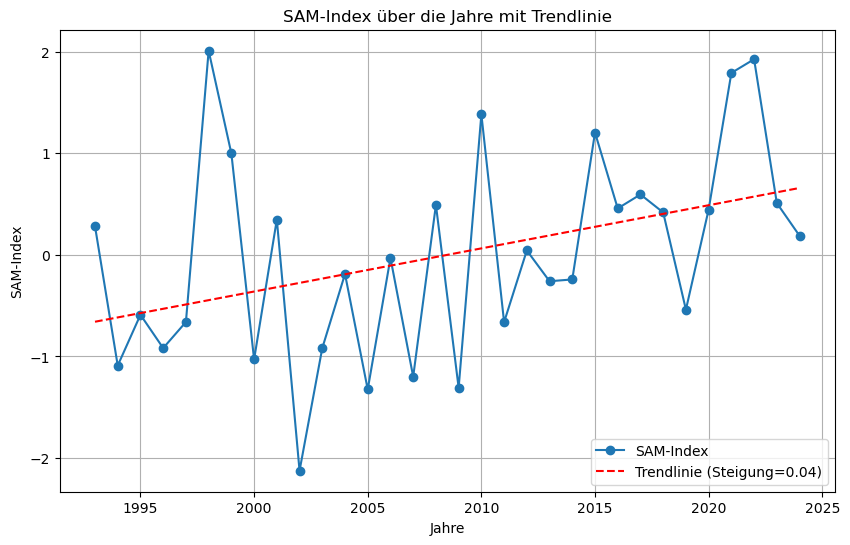

In [7]:
## Plotten SAM-Index über Jahre
# ! Vergleich mit Figure 1 (a) aus Paper 1: 1_Recent trends in the Southern Ocean eddy field --> nicht ganz passend -> ausreichend?

# Zeitkoordinate und SAM-Index-Werte extrahieren
jahre = sam_index['year'].values  # Zeitkoordinate
sam_values = sam_index.values  # SAM-Index-Werte

# Berechnung der Trendlinie (Lineare Regression)
slope, intercept, r_value, p_value, std_err = linregress(jahre, sam_values)
trendline = slope * jahre + intercept

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(jahre, sam_values, label='SAM-Index', linestyle='-', marker='o')
plt.plot(jahre, trendline, label=f'Trendlinie (Steigung={slope:.2f})', color='red', linestyle='--')

# Plot-Details hinzufügen
plt.xlabel('Jahre')
plt.ylabel('SAM-Index')
plt.title('SAM-Index über die Jahre mit Trendlinie')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
## Einheitsvektoranalyse

In [9]:
# 1. bereits Daten vorbereitet (SLP über Zeit und Raum, normeirt)

In [10]:
# 2. EOF-Analyse (= Empirical Orthonogal Function)
# 2.1 Kovarianzmatrix der Felder 
C = np.cov(X_centered, rowvar=False)  # rowvar=False, da Spalten die Variablen sind
# 2.2 löse Eigenwertproblem -> Eigenvektoren und dazu gehörige Eigenwerte
eigenvalues, eigenvectors = np.linalg.eigh(C)  # 'eigh', da C symmetrisch ist
# 2.3 EOFs sind orthogonale räumliche Muster (Eigenwerte und Eigenvektoren sortieren (absteigende Reihenfolge der Eigenwerte))
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
# -> EOFs sind die Eigenvektoren der Kovarianzmatrix
# -> EOFs repräsentieren orthogonale räumliche Muster

NameError: name 'X_centered' is not defined

In [ ]:
# 3. Skalarprodukt und Projektion
# 3.1 Berechne Skalarprodukt eines gegebenen räumlichen Musters (z. B. ENSO oder SAM)
# Beispiel: Ein zufälliges ENSO-Muster (als Proxy)
enso_pattern = np.random.rand(n_space)  # Ersetze dies durch das echte ENSO-Muster
enso_projection = np.dot(eigenvectors.T, enso_pattern)

# (b) Das Skalarprodukt zeigt an, wie stark das ENSO-Muster auf das EOF-Feld projiziert wird
print("ENSO-Projektionen auf EOFs:", enso_projection)

In [11]:
# 4. Orthogonalität
# EOFs bilden eine orthogonale Basis
# Prüfen, ob das ENSO-Muster hauptsächlich parallel zu einem spezifischen EOF ist
# Beispiel: Korrelation der ENSO-Projektionen mit den Eigenvektoren
correlation_with_eof = [np.dot(enso_pattern, eigenvectors[:, i]) for i in range(len(eigenvectors[0]))]
print("ENSO-Korrelation mit EOFs:", correlation_with_eof)

# Falls eine hohe Korrelation vorliegt, ist das ENSO-Muster mit dem spezifischen EOF korreliert.
# Wenn nahezu orthogonal, hat ENSO wenig Einfluss auf das spezifische EOF.

NameError: name 'eigenvectors' is not defined

In [12]:
# 5. Visualisierung
# EOF 1 (Erstes Eigenvektor-Muster)
plt.figure(figsize=(8, 6))
plt.plot(eigenvectors[:, 0], label='EOF 1')
plt.title("EOF 1 (Räumliches Muster)")
plt.xlabel("Räumliche Gitterpunkte")
plt.ylabel("EOF-Wert")
plt.legend()
plt.grid()
plt.show()

# Zeitliche Variation von EOF 1 (Principal Component 1)
principal_components = np.dot(X_centered, eigenvectors)
plt.figure(figsize=(8, 6))
plt.plot(principal_components[:, 0], label='PC 1')
plt.title("PC 1 (Zeitliche Variation von EOF 1)")
plt.xlabel("Zeit")
plt.ylabel("PC-Wert")
plt.legend()
plt.grid()
plt.show()

# Erklärte Varianz plotten
explained_variance = eigenvalues / np.sum(eigenvalues) * 100
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, label='Erklärte Varianz')
plt.title("Erklärte Varianz durch EOFs")
plt.xlabel("EOF-Index")
plt.ylabel("Erklärte Varianz (%)")
plt.legend()
plt.grid()
plt.show()

NameError: name 'eigenvectors' is not defined

<Figure size 800x600 with 0 Axes>